### Before continuing, make sure you have Wiki DB installed and in the same directory as this program. See README for link

## Description of Data Set and CNN goal
The Convolutional Neural Network (CNN) built in this project aims to recognize and classify images of faces based on the provided metadata. <br>
Specifically, the CNN will be trained to:
Identify the Gender and Predict the Age of a person based on their face.

## Import Dependencies 

In [148]:
import scipy.io
import os
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta
import splitfolders
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.models import Model




## Load Relevant Metadata

In [149]:
# Path to the local dataset directory
import numpy as np


data_dir = './wiki'

# Path to the metadata file
metadata_file = os.path.join(data_dir, 'wiki.mat')

# Load the metadata from the .mat file
metadata = scipy.io.loadmat(metadata_file)
# Extract the relevant metadata
wiki_data = metadata['wiki'][0, 0]
all_image_paths = wiki_data['full_path'][0]
print(all_image_paths)
names = wiki_data['name'][0]
genders = wiki_data['gender'][0]
birthdates = wiki_data['dob'][0]
photo_taken = wiki_data['photo_taken'][0]

# Calculate age
# Function to convert MATLAB serial date number to a readable date
def convert_dob(dob):
    reference_date = datetime(1, 1, 1)
    days_since_reference = int(dob)
    actual_date = reference_date + timedelta(days=days_since_reference - 366)
    return actual_date.strftime("%Y-%m-%d")  # Format as Year-Month-Day

# Calculate ages
ages = []
for dob, photo_year in zip(birthdates, photo_taken):
    birthdate = convert_dob(dob)
    age = photo_year - int(birthdate[:4])

    ages.append(age)

ages = np.array(ages)
# MATLAB's reference date (0 days since year 0)
reference_date = datetime(1, 1, 1)



[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31')
 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31')
 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29') ...
 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30')
 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30')
 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]


## Visualize 5 examples 

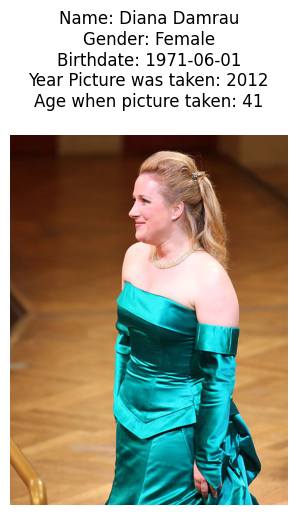

In [150]:

# Function to display an image with its metadata
def display_image_with_metadata(image_path, name, gender, dob, photo_taken, age):
    # Construct the full image path
    full_image_path = os.path.join(data_dir, image_path[0])
    birthdate_str = convert_dob(dob)

    # Open and display the image
    image = Image.open(full_image_path)
    plt.imshow(image)
    plt.imshow(image)
    title = (f"Name: {name[0]}\n"
            f"Gender: {'Male' if gender == 1 else 'Female' }\n"
             f"Birthdate: {birthdate_str}\n"
             f"Year Picture was taken: {photo_taken}\n"
             # Can be off by 1 year, since db does not have month/day picture was taken
             f"Age when picture taken: {age}\n"
             )
    plt.title(title)
    plt.axis('off')
    # plt.show()

# Display a few images with their metadata
for i in range(5):
    display_image_with_metadata(all_image_paths[i], names[i], genders[i], birthdates[i], photo_taken[i], ages[i])
    

## Split Data


In [151]:
# Split data between training and testing
# Check if the directory with split data already exists
if not os.path.exists("./wiki_split_data"):
    # Split data between training and testing
    splitfolders.ratio('./wiki', output="./wiki_split_data", seed=1337, ratio=(0.7, 0.15, 0.15))


## Build Model

In [152]:
# Input layer
input_layer = Input(shape=(64, 64, 3))

# Shared layers
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)

# Output layers
age_output = Dense(units=1, activation='linear', name='age_output')(x)  # Regression for age
gender_output = Dense(units=1, activation='sigmoid', name='gender_output')(x)  # Binary classification for gender

# Define the model
model = Model(inputs=input_layer, outputs=[age_output, gender_output])

# Print the model summary
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 131072)    │          0 │ conv2d_10[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │ 16,777,344 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        129 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        129 │ dense_10[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,778,498 (64.00 MB)

 Trainable params: 16,778,498 (64.00 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
import os
import numpy as np

def extract_labels(image_paths, all_image_paths, ages, genders):
    # Create empty lists to hold the extracted ages and genders
    extracted_ages = []
    extracted_genders = []

    # Loop through the image paths in the split dataset
    for path in image_paths:
        # Print the path being checked
        print(f'Checking path: {path}')
        # Get the index of the image path in the original metadata
        index = np.where(all_image_paths == path) # Adjusted to use path directly

        if len(index) > 0:
            print('Image found')
            extracted_ages.append(ages[index[0]])  # Append the age
            extracted_genders.append(genders[index[0]])  # Append the gender
        else:
            print(f'No match found for: {path}')  # Print if no match is found

    return np.array(extracted_ages), np.array(extracted_genders)

# Function to get all image paths in a directory
def get_image_paths(directory):
    image_paths = []
    for root, _, files in os.walk(directory):  # Walk through directory
        for file in files:
            print(f'Checking file: {file} in {root[-2:]}')
            if file.endswith(('.jpg')):  # Include only image files
                print(f'Found image: {file}')
                # add name of folder to image path
                image_paths.append(f"{root[-2:]}/{file}")  # Join path correctly
    return image_paths

# Use the function to get training, validation, and test image paths
train_image_paths = get_image_paths('./wiki_split_data/train')
val_image_paths = get_image_paths('./wiki_split_data/val')
test_image_paths = get_image_paths('./wiki_split_data/test')

# Print out the paths to verify
print("Train Image Paths:", train_image_paths)
print("Validation Image Paths:", val_image_paths)
print("Test Image Paths:", test_image_paths)

# Prepare labels for training
y_train_ages, y_train_genders = extract_labels(train_image_paths, all_image_paths, ages, genders)

# Prepare labels for validation
y_val_ages, y_val_genders = extract_labels(val_image_paths, all_image_paths, ages, genders)

# Prepare labels for test dataset
y_test_ages, y_test_genders = extract_labels(test_image_paths, all_image_paths, ages, genders)

# Check the shapes to confirm
print(f'y_train_ages shape: {y_train_ages.shape}')
print(f'y_train_genders shape: {y_train_genders.shape}')
print(f'y_val_ages shape: {y_val_ages.shape}')
print(f'y_val_genders shape: {y_val_genders.shape}')
print(f'y_test_ages shape: {y_test_ages.shape}')
print(f'y_test_genders shape: {y_test_genders.shape}')


Checking file: 10049200_1891-09-16_1958.jpg in 00
Found image: 10049200_1891-09-16_1958.jpg
Checking file: 10126400_1964-07-07_2010.jpg in 00
Found image: 10126400_1964-07-07_2010.jpg
Checking file: 1013900_1917-10-15_1960.jpg in 00
Found image: 1013900_1917-10-15_1960.jpg
Checking file: 10166400_1960-03-12_2008.jpg in 00
Found image: 10166400_1960-03-12_2008.jpg
Checking file: 102100_1970-10-09_2008.jpg in 00
Found image: 102100_1970-10-09_2008.jpg
Checking file: 1024100_1982-06-07_2011.jpg in 00
Found image: 1024100_1982-06-07_2011.jpg
Checking file: 10292500_1984-03-26_2009.jpg in 00
Found image: 10292500_1984-03-26_2009.jpg
Checking file: 1035700_1945-11-27_2013.jpg in 00
Found image: 1035700_1945-11-27_2013.jpg
Checking file: 10416800_1907-01-08_1967.jpg in 00
Found image: 10416800_1907-01-08_1967.jpg
Checking file: 10525500_1916-02-14_1951.jpg in 00
Found image: 10525500_1916-02-14_1951.jpg
Checking file: 1054800_1947-09-19_2011.jpg in 00
Found image: 1054800_1947-09-19_2011.jpg


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Image found
Checking path: 00/10126400_1964-07-07_2010.jpg
Image found
Checking path: 00/1013900_1917-10-15_1960.jpg
Image found
Checking path: 00/10166400_1960-03-12_2008.jpg
Image found
Checking path: 00/102100_1970-10-09_2008.jpg
Image found
Checking path: 00/1024100_1982-06-07_2011.jpg
Image found
Checking path: 00/10292500_1984-03-26_2009.jpg
Image found
Checking path: 00/1035700_1945-11-27_2013.jpg
Image found
Checking path: 00/10416800_1907-01-08_1967.jpg
Image found
Checking path: 00/10525500_1916-02-14_1951.jpg
Image found
Checking path: 00/1054800_1947-09-19_2011.jpg
Image found
Checking path: 00/10726900_1991-02-03_2010.jpg
Image found
Checking path: 00/10870400_1971-06-28_2013.jpg
Image found
Checking path: 00/10967900_1956-03-18_2007.jpg
Image found
Checking path: 00/11328300_1980-06-10_2008.jpg
Image found
Checking path: 00/1138200_1963-02-24_2014.jpg
Image found
Checking path: 00/1142200_1980-03-17_2010.jpg
Image found
Checking path: 00/11435300_1959-12-26_1950.jpg
Image